In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import time
import datetime
# nltk.download('stopwords')

from scipy.sparse import hstack
from nltk.corpus import stopwords
from itertools import product
from sklearn import decomposition, metrics
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, roc_curve, mean_squared_error, make_scorer
from sklearn.pipeline import FeatureUnion
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import train_test_split
from utility.processing import processer
from utility.utility import *
%matplotlib inline

from imblearn.combine import *
from imblearn.over_sampling import *
from imblearn.under_sampling import * 
from imblearn.pipeline import Pipeline

# LSA

## 데이터 로드

In [10]:
train = pd.read_csv('./data/preprocessed_train.csv')
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)
y = train.median_relevance.values

In [15]:
len(train.groupby('median_relevance').get_group(4))/len(train)

0.6075014766686355

In [3]:
train, dev, y, y_dev = train_test_split(train, y, stratify=y, test_size=0.1)

In [4]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

## 모델링

In [5]:
# https://datascience.stackexchange.com/questions/28598/word2vec-embeddings-with-tf-idf
# https://stackoverflow.com/questions/47727078/what-does-a-weighted-word-embedding-mean
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [6]:
# # 가장 많이 쓰인 단어
# processer.words_freq_sort(traindata)[:20]

### TF-IDF

In [7]:
# min_df=3 : 빈도수가 3번 이하인 단어 무시  
# max_features=None : 단어 빈도수의 맥시멈 설정 x
# strip_accents='unicode' : 모든 특수문자와 pattern을 정재할수 없으므로 unicode사용       
# analyzer='word' : corpus가 문장 list로 이루어져있어 단어단위로 분석  
# token_pattern=r'\w{1,}' : analyzer == 'word'일 때 token_pattern을 기반으로 단어 인식   
# ngram_range=(1, 3) : word window의 범위 1~3, 약 90% 쿼리가 word size 3이하로 이루어짐  
# use_idf=True : idf사용   
# smooth_idf=True : 분모가 0이 되는것을 방지  
# sublinear_tf=True : 단어 스무딩, replace 1 + log(tf).   
# stop_words : 불용어 제거  
stop_words = text.ENGLISH_STOP_WORDS.union(['http','www','img','border','color','style','padding','table','font', '',\
                                            'thi','inch','ha','width','height','0','1','2','3','4','5','6','7','8','9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}', \
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True, \
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [8]:
# 단어별 가중치 확인
# idf_dict = dict(zip(tfv.get_feature_names(), tfv.idf_))

### cos, jaccard similarlity

In [9]:
# query, title 유사도 계산(cos, jaccard)
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

In [10]:
for i in range(1, 5):
    sims = X_sim_train.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
cos_sim mean : 0.135548	 jaccard_sim mean: 0.090633

ratings 2 
cos_sim mean : 0.228035	 jaccard_sim mean: 0.156851

ratings 3 
cos_sim mean : 0.284979	 jaccard_sim mean: 0.197869

ratings 4 
cos_sim mean : 0.357721	 jaccard_sim mean: 0.250929



In [ ]:
lr = LogisticRegression(max_iter=500)

X_train_sim = hstack([X_train, X_sim_train])
X_dev_sim = hstack([X_dev, X_sim_dev])

cv = StratifiedKFold(n_splits=5, shuffle=True)
lr.fit(X_train, y)
kappa_scores = cross_val_score(lr, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr without sim kappa score 평균 : %0.2d, 편차 : %0.2d" % (np.mean(kappa_scores), np.std(kappa_scores)))
      
lr.fit(X_train_sim, y)
kappa_scores = cross_val_score(lr, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr with sim kappa score 평균 : %0.2d, 편차 : %0.2d" % (np.mean(kappa_scores), np.std(kappa_scores)))

### LSA

In [13]:
# TruncatedSVD
# 261개의 쿼리이므로 n_components = 250로 모델링 시작
svd = TruncatedSVD(n_components = 250)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

In [ ]:
# LSA 이후의 유사도 계산
# TF-IDF로 구한 유사도 보다 높은값이지만 증가비율은 비슷함
tfidf_hat = np.dot(X_svd_train, svd.components_)
cos_sims = []
jaccard_sims = []
half = 10316
for row in tfidf_hat:
    front = row[:half]
    end = row[half:]
    cos_sims.append(metric.cos_sim(front, end))
    jaccard_sims.append(metric.jaccard_sim(front, end))
    
simsim = sparse.csr_matrix(np.matrix([x for x in zip(cos_sims, jaccard_sims)]))

for i in range(1, 5):
    sims = simsim.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

In [15]:
# Truncated SVD와 유사도 hstack
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

In [16]:
# StandardScaler
# with_mean=False 행렬이 희소하고 [0,1]이므로 mean shift사용 X
scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

### classification(LogisticRegression)

In [17]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_scaled_train, y)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("kappa score 평균 : %0.2d, 편차 : %0.2d" % (np.mean(kappa_scores), np.std(kappa_scores)))

0.5045108571838828

### classification(SVM)

In [20]:
# C=100(패널티) 문서당 유사도가 크기때문에(쿼리의 중복) 100으로 잡고 시작
svm = SVC(C = 100, gamma='auto', probability=True)
svm_result = svm.fit(X_scaled_train, y)
svm_pred_dev = svm_result.predict(X_scaled_dev)

kappa_scores = cross_val_score(svm, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("kappa score 평균 : %0.2d, 편차 : %0.2d" % (np.mean(kappa_scores), np.std(kappa_scores)))

## 모델링 결과 해석

kappa
train : 0.904973	dev : 0.658530
rmse
train : 0.426635	dev : 0.813881

confusion_matrix : 1016개중 325개를 틀림
 [[ 46  21   6   4]
 [ 21  56  26  45]
 [  6  29  49  90]
 [  8  27  42 540]]

classification_report :
               precision    recall  f1-score   support

           1       0.57      0.60      0.58        77
           2       0.42      0.38      0.40       148
           3       0.40      0.28      0.33       174
           4       0.80      0.88      0.83       617

    accuracy                           0.68      1016
   macro avg       0.55      0.53      0.54      1016
weighted avg       0.66      0.68      0.66      1016



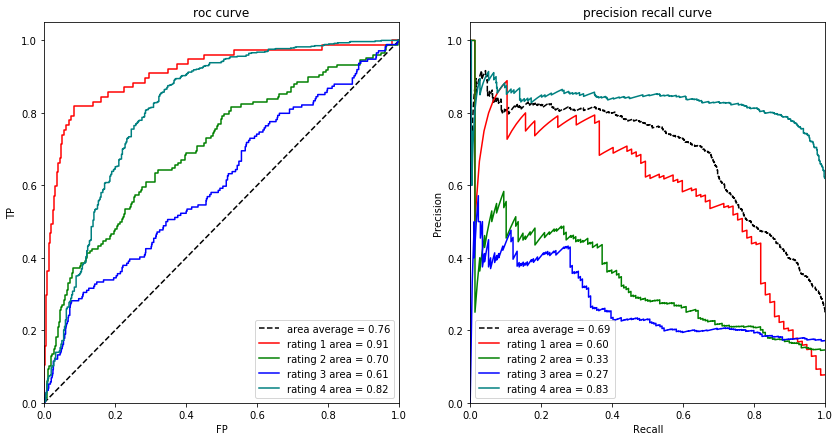

In [22]:
print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      metrics.confusion_matrix(y_dev, svm_pred_dev))

print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

## 개선된 모델

kappa
train : 0.966579	dev : 0.615538
rmse
train : 0.288649	dev : 0.857459

confusion_matrix : 1016개중 379개를 틀림
 [[ 47  20   3   7]
 [ 20  55  36  37]
 [  6  24  62  82]
 [  6  42  96 473]]

classification_report :
               precision    recall  f1-score   support

           1       0.59      0.61      0.60        77
           2       0.39      0.37      0.38       148
           3       0.31      0.36      0.33       174
           4       0.79      0.77      0.78       617

    accuracy                           0.63      1016
   macro avg       0.52      0.53      0.52      1016
weighted avg       0.64      0.63      0.63      1016



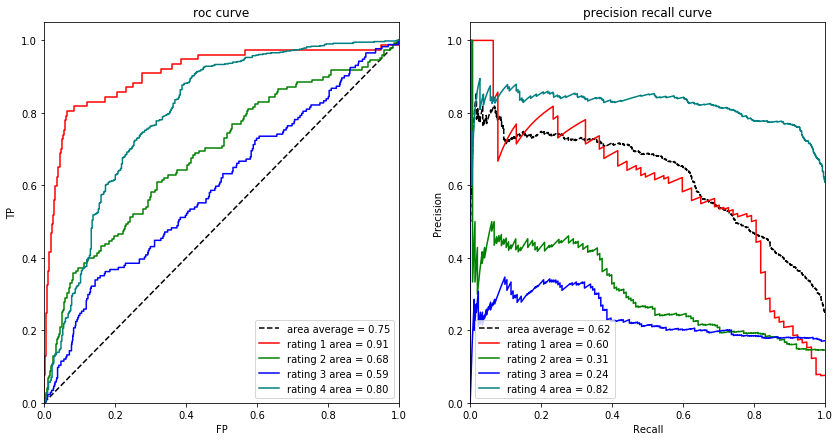

In [28]:
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_samp, y_samp = smt.fit_sample(X_scaled_train, y)

svm = SVC(C=100, gamma='auto', class_weight='balanced'  probability=True)
svmresult = svm.fit(X_samp, y_samp)

svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      metrics.confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

#### GridSearchCV(SVM)

In [2]:
df_train = pd.read_csv('./data/preprocessed_train.csv')
Y = df_train['median_relevance']
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)

In [ ]:
# n_components, C, gamma
parmas = [[230], [1000], ['auto']]
parmas = list(product(*parmas))

results = gridsearchcv(df_train, Y, parmas)

In [ ]:
results

In [ ]:
train = pd.read_csv('./data/preprocessed_train.csv')
y = train['median_relevance']
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)

In [ ]:
param_grid = {'n_components' : 230,\
              'C' : 100,\
              'gamma' : 'auto'}

In [ ]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

stop_words = text.ENGLISH_STOP_WORDS.union(['http','www','img','border','color','style','padding','table',\
                                            'font', '', 'thi','inch','ha','width','height',\
                                            '0','1','2','3','4','5','6','7','8','9'])

stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))
tfv = text.TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',\
                           token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=True, smooth_idf=True, \
                           sublinear_tf=True, stop_words = stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

sim = similarlity_stack()
svd = TruncatedSVD(n_components = param_grid['n_components'])
scl = StandardScaler(with_mean=False)
smote = SMOTE(sampling_strategy='auto')
svm = SVC(C=param_grid['C'], gamma=param_grid['gamma'], probability=True)

X_sim_train = sim.fit_transform(X_train, y)
X_svd_train = svd.fit_transform(X_train)
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_scaled_train = scl.fit_transform(X_stacked_train)

X_sim_test = sim.transform(X_test)       
X_svd_test = svd.transform(X_test)
X_stacked_test = hstack([X_svd_test, X_sim_test])
X_scaled_test = scl.transform(X_stacked_test)

X_samp, y_samp = smote.fit_sample(X_scaled_train, y)

svm_result = svm.fit(X_samp, y_samp)
svm_pred_test = svm_result.predict(X_scaled_test)
            
# submission = pd.DataFrame({"id": idx, "prediction": svm_pred_test})
# submission.to_csv("./submission/submission.csv", index=False)
# submission.head()

In [ ]:
sim = similarlity_stack()
svd = TruncatedSVD()
scl = StandardScaler(with_mean=False)
sampling = OneSidedSelection()
svm =  SVC(gamma='auto', class_weight='balanced', probability=True)

clf = Pipeline([('FeatureUnion', FeatureUnion( [('svd', svd), ('sim', sim)] )),\
                ('scl', scl),\
                ('sampling', sampling),\
                ('svm', svm)])


svd__n_components = [230]
sampling__sampling_strategy = ['majority']
svm__C = [100]

param_grid = {'FeatureUnion__svd__n_components' : svd__n_components,\
              'sampling__sampling_strategy' : sampling__sampling_strategy,\
              'svm__C': svm__C}

scoring = {'kappa': make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), \
           'pr_auc': make_scorer(metric.pr_auc_score, greater_is_better = True, needs_proba=True, average='micro')}

import os
cv = os.cpu_count()
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, \
                     refit='kappa', verbose=10, n_jobs=-1, iid=True, cv=cv)

model.fit(X_train, y)
results = pd.DataFrame(model.cv_results_)
# results.to_csv("./gridsearch/results.csv", index=False)

In [161]:
# best 점수, parameters 확인
print("Best score: %0.3f" % model.best_score_)
print("Best parameters :")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.487
Best parameters :
	FeatureUnion__svd__n_components: 300
	sampling__sampling_strategy: 'not minority'


In [ ]:
best_model = model.best_estimator_
best_model.fit(X_train, y)
dev_preds = best_model.predict(X_dev)
model_preds = best_model.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_dev, dev_preds))
print(classification_report(y_dev, dev_preds))
plot_multiclass_roc_prc(best_model, X_dev, y_dev)

In [134]:
# # save submission
# grid_svm_sim_submission = pd.DataFrame({"id": idx, "prediction": model_preds})
# grid_svm_sim_submission.to_csv("./submission/tfidf_svm_sim_grid.csv", index=False)
# grid_svm_sim_submission.head()

,id,prediction
0,3,4
1,6,3
2,9,3
3,11,4
4,12,4


In [ ]:
def gridsearchcv(X, Y, parmas):
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    parmas = parmas
    
    param_list = []
    cv_kappa_score_mean = []
    cv_kappa_score_std = []
    cv_pr_auc_score_mean = []
    cv_pr_auc_score_std = []
    
    for param in parmas:
        start = time.time()
        param_grid = {'n_components' : param[0],\
                      'C' : param[1], \
                      'gamma' : param[2]}
        
        cv_kappa_scores = []
        cv_pr_auc_scores = []
        for train_idx, dev_idx in kf.split(X, Y):

            train, dev = X.iloc[train_idx], X.iloc[dev_idx]
            y, y_dev = Y.iloc[train_idx], Y.iloc[dev_idx]
        
            train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
            train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

            dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
            dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

            stop_words = text.ENGLISH_STOP_WORDS.union(['http','www','img','border','color','style','padding','table',\
                                                        'font', '', 'thi','inch','ha','width','height',\
                                                        '0','1','2','3','4','5','6','7','8','9'])
            
            stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))
            tfv = text.TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',\
                                       token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=True, smooth_idf=True, \
                                       sublinear_tf=True, stop_words = stop_words).fit(train_query + train_title)
            
            X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
            X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
            
            sim = similarlity_stack()
            svd = TruncatedSVD(n_components = param_grid['n_components'])
            scl = StandardScaler(with_mean=False)
            smote = SMOTE(sampling_strategy='auto')
            svm = SVC(C=param_grid['C'], gamma=param_grid['gamma'], probability=True)

            X_sim_train = sim.fit_transform(X_train, y)
            X_svd_train = svd.fit_transform(X_train)
            X_stacked_train = hstack([X_svd_train, X_sim_train])
            X_scaled_train = scl.fit_transform(X_stacked_train)

            X_sim_dev = sim.transform(X_dev)       
            X_svd_dev = svd.transform(X_dev)
            X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
            X_scaled_dev = scl.transform(X_stacked_dev)

            X_samp, y_samp = smote.fit_sample(X_scaled_train, y)

            svm_result = svm.fit(X_samp, y_samp)
            svm_pred_dev = svm_result.predict(X_scaled_dev)
            svm_pred_proba_dev = svm_result.predict_proba(X_scaled_dev)

            cv_kappa_scores.append(metric.quadratic_weighted_kappa(y_dev, svm_pred_dev))
            cv_pr_auc_scores.append(metric.pr_auc_score(y_dev, svm_pred_proba_dev))
            
        
        param_list.append(param_grid)
        cv_kappa_score_mean.append(np.mean(cv_kappa_scores))
        cv_kappa_score_std.append(np.std(cv_kappa_scores))
        cv_pr_auc_score_mean.append(np.mean(cv_pr_auc_scores))
        cv_pr_auc_score_std.append(np.std(cv_pr_auc_scores))

        print(param_grid, "kappa_score : %.2f, pr_auc_scores : %.2f"% (np.mean(cv_kappa_scores), np.mean(cv_pr_auc_scores)))
        print("time : %s"%(str(datetime.timedelta(seconds=int(time.time() - start)))))  
        
    results = pd.DataFrame({'param' : param_list, \
                            'kappa_score_mean' : cv_kappa_score_mean, \
                            'kappa_score_std' : cv_kappa_score_std, \
                            'pr_auc_score_mean' : cv_pr_auc_score_mean, \
                            'pr_auc_score_std' : cv_pr_auc_score_std})
    
    return results
